In [ ]:
seed = 31

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = Warning)

import numpy as np
from collections import Counter
np.random.seed(seed)

import logging

import random
random.seed(seed)

#tf.keras.mixed_precision.set_global_policy('mixed_float16')

import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
import time
import os

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

In [ ]:
# prompt: connect to gdrive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

# Dictionary to store closing prices for each stock
closing_prices = {}

# Path to the directory containing S&P 500 CSV files
sp500_dir = '/content/drive/My Drive/csv'

# Iterate through CSV files in the directory
for filename in os.listdir(sp500_dir):
    if filename.endswith('.csv'):
        ticker = filename.split('.')[0]
        file_path = os.path.join(sp500_dir, filename)

        try:
            # Read CSV file
            df = pd.read_csv(file_path)

            # Check if 'Close' column exists
            if 'Close' not in df.columns:
                print(f"Error: 'Close' column not found in {filename}")
                print(f"Available columns: {df.columns.tolist()}")
                continue

            # Extract closing prices and convert to numpy array
            closing_data = df['Close'].to_numpy()

            # Check if closing_data is not empty before adding to the dictionary
            if closing_data is not None and len(closing_data) > 0 and not np.isnan(closing_data).any():
                # Save closing data in the dictionary
                closing_prices[ticker] = closing_data
                print(f"Loaded {len(closing_data)} closing prices for {ticker}")
            else:
                print(f"No closing prices loaded for {ticker}")

        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")

# Print the total number of stocks loaded
print(f"\nTotal number of stocks loaded: {len(closing_prices)}")

# Print a sample of the data to verify
if closing_prices:
    sample_ticker = next(iter(closing_prices))
    print(f"\nSample data for {sample_ticker}:")
    print(closing_prices[sample_ticker][:5])
else:
    print("\nNo data loaded. Check the file paths and CSV format.")


Loaded 10778 closing prices for ADI
Loaded 10778 closing prices for ABT
Loaded 4333 closing prices for AAL
Loaded 6278 closing prices for AEE
Loaded 5296 closing prices for AAP
Loaded 5804 closing prices for A
Loaded 8916 closing prices for ABMD
Loaded 10778 closing prices for ADP
Loaded 6973 closing prices for ABC
Loaded 5385 closing prices for ACN
Loaded 10778 closing prices for ADM
Loaded 13356 closing prices for AEP
Loaded 9441 closing prices for ADSK
Loaded 10590 closing prices for AAPL
Loaded 2505 closing prices for ABBV
Loaded 10990 closing prices for APA
Loaded 12514 closing prices for BF-A
Loaded 10778 closing prices for CAG
Loaded 10791 closing prices for BIO
Loaded 3687 closing prices for AWK
Loaded 6121 closing prices for CCI
Loaded 1287 closing prices for ALTR
Loaded 7387 closing prices for BWA
Loaded 12514 closing prices for BK
Loaded 13356 closing prices for CAT
No closing prices loaded for BHI
Loaded 9882 closing prices for AOS
Loaded 10778 closing prices for CDE
Loaded

In [ ]:
from sklearn.preprocessing import RobustScaler

def create_sequences(data, seq_length, telescope, stride=1):
    x = []
    y = []
    for i in range(0, len(data) - seq_length - telescope + 1, stride):

        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+telescope])
    return np.array(x), np.array(y)

# Sequence length
seq_length = 360
telescope = 30

# Dictionary to store training sequences for each stock
x = []
y = []

for symbol, prices in closing_prices.items():
    if len(prices) >= seq_length:
        x_temp, y_temp = create_sequences(prices, seq_length, telescope, stride = 30)
        x.append(x_temp)
        y.append(y_temp)
    else:
        print(f"Warning: Not enough data for {symbol}. Needed {seq_length}, but only had {len(prices)}")

x = np.concatenate(x, axis=0)
y = np.concatenate(y, axis=0)


print(x.shape)
print(y.shape)



(101701, 360)
(101701, 30)


In [ ]:
import numpy as np
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm


scaler = RobustScaler()
scaled = scaler.fit_transform(x)

def applyRobustScaler(data):
    elements = []

    # Use tqdm to track the progress of the loop
    for el in tqdm(data, desc="Normalizing Sequences"):
        scaler = RobustScaler()
        reshaped = el.reshape(-1, 1)
        scaled = scaler.fit_transform(reshaped)
        normalized = scaled.flatten()

        elements.append(normalized)

    return np.array(elements)

In [ ]:
print(x.shape)
print(y.shape)

(101701, 360)
(101701, 30)


In [ ]:
has_nan = np.isnan(x).any()

if has_nan:
    print("The array contains NaN values.")
    np.savetxt('array_with_nan_txt.csv', x)
else:
    print("The array does not contain NaN values.")

The array does not contain NaN values.


In [ ]:
from sklearn.preprocessing import RobustScaler

test_size = round(len(x) * 0.1)
val_size = round(len(x) * 0.2)

train_size = len(x) - test_size - val_size

print(np.concatenate((x, y), axis=1).shape)

transformer = RobustScaler().fit(np.concatenate((x, y), axis=1))
val = np.concatenate((x[test_size:test_size + val_size], y[test_size:test_size+val_size]), axis=1)
train = np.concatenate((x[test_size + val_size:], y[test_size + val_size:]), axis=1)

print(train.shape)
print(val.shape)

x_test, y_test = x[:test_size], y[:test_size]
x_val, y_val = val[:,:360], val[:,360:]
x_train, y_train = train[:,:360], train[:,360:]

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)



(101701, 390)
(71191, 390)
(20340, 390)
(71191, 360) (71191, 30) (20340, 360) (20340, 30) (10170, 360) (10170, 30)


In [ ]:
# Reshape the data to (x, y, 1) format
x_train = x_train[:,:, np.newaxis]
y_train = y_train[:,:, np.newaxis]
x_test = x_test[:,:, np.newaxis]
y_test = y_test[:,:, np.newaxis]
x_val = x_val[:,:, np.newaxis]
y_val = y_val[:,:, np.newaxis]

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((71191, 360, 1),
 (71191, 30, 1),
 (10170, 360, 1),
 (10170, 30, 1),
 (20340, 360, 1),
 (20340, 30, 1))

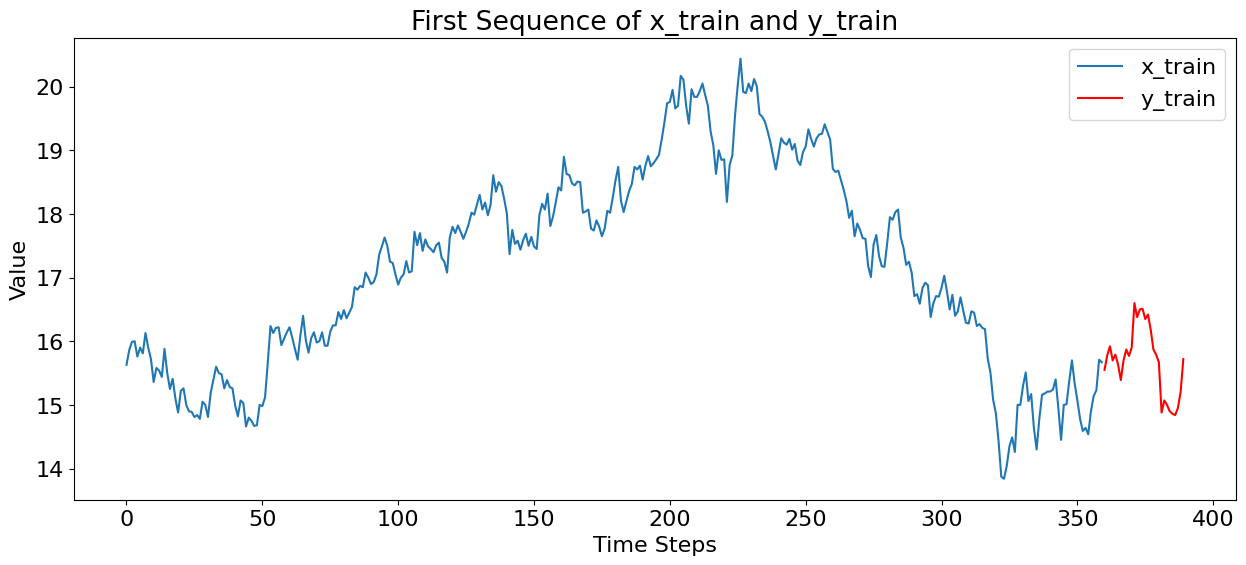

In [ ]:
# prompt: plot the first sequence of x_train on seaborn, then highlight y_train

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming x_train and y_train are numpy arrays

# Get the first sequence from x_train and y_train
first_x_sequence = x_train[1, :, 0]
first_y_sequence = y_train[1, :, 0]

# Create a range for the x-axis (time steps)
x_axis = np.arange(len(first_x_sequence))

# Create a figure and axes
plt.figure(figsize=(15, 6))
ax = sns.lineplot(x=x_axis, y=first_x_sequence, label="x_train")

# Highlight the y_train sequence
start_index_y = len(first_x_sequence)
end_index_y = len(first_x_sequence) + len(first_y_sequence)
x_axis_y = np.arange(start_index_y, end_index_y)
ax = sns.lineplot(x=x_axis_y, y=first_y_sequence, label="y_train", color='red')

plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.title("First Sequence of x_train and y_train")
plt.legend()
plt.show()


In [ ]:
#model architecture
class LSTMCNN_Model(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(LSTMCNN_Model, self).__init__()
        self.lstm = nn.LSTM(input_size=input_shape[-1], hidden_size=64, batch_first=True)

        self.cnn1 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.cnn2 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.cnn3 = nn.Conv1d(256, 512, kernel_size=3, padding=1)

        self.pool = nn.MaxPool1d(2)
        self.gap = nn.AdaptiveAvgPool1d(1)

        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.1)

        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, output_shape)

        self.relu = nn.ReLU()

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x.transpose(1, 2)  # Change shape for Conv1d

        x = self.relu(self.cnn1(x))
        x = self.pool(x)

        x = self.relu(self.cnn2(x))
        x = self.pool(x)

        x = self.relu(self.cnn3(x))
        x = self.gap(x).squeeze(-1)

        x = self.dropout1(x)
        x = self.relu(self.fc1(x))

        x = self.dropout2(x)
        x = self.relu(self.fc2(x))

        x = self.fc3(x)

        return x


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=30, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out)  # Transform all time steps' outputs
        return out

In [ ]:
#check for GPU support
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def buildModel(input_shape, output_shape):
    model = LSTMCNN_Model(input_shape, output_shape).to(device)

    loss_fn = nn.MSELoss(reduction='mean')

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    return model, optimizer, loss_fn

'''
input_size = x_train.shape[1:]
output_size = y_train.shape[1]



print(input_size, output_size)


num_layers = 3  # Increased number of layers
hidden_size = 128  # Increased number of hidden units
dropout = 0.2


model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout).to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-3)

batch_size = 32
num_epochs = 200


train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
'''

"\ninput_size = x_train.shape[1:]\noutput_size = y_train.shape[1]\n\n\n\nprint(input_size, output_size)\n\n\nnum_layers = 3  # Increased number of layers\nhidden_size = 128  # Increased number of hidden units\ndropout = 0.2 \n\n\nmodel = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout).to(device)\nloss_fn = nn.MSELoss(reduction='mean')\noptimizer = optim.Adam(model.parameters(), lr=1e-3)\n\nbatch_size = 32\nnum_epochs = 200\n\n\ntrain_dataset = TensorDataset(x_train, y_train)\ntrain_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)\nval_dataset = TensorDataset(x_val, y_val)\nval_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)\n"

In [ ]:
from tqdm.auto import tqdm
np.set_printoptions(threshold=np.inf)
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    # Removed early stopping and scheduler
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        with open('training_log.txt', 'w') as log_file:
            train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=True)
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)
                labels = labels.reshape(outputs.shape)
                loss = criterion(outputs, labels)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                train_bar.set_postfix({'loss': loss.item()})
                train_bar.update()
        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                labels = labels.reshape(outputs.shape)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}')

    return model


In [ ]:
from torch.utils.data import DataLoader, TensorDataset
input_size = x_train.shape[1:]
output_size = y_train.shape[1]
batch_size = 32
num_epochs = 100


# Assuming x_train, y_train are numpy arrays
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Create TensorDataset and DataLoader for training
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Assuming you have validation data x_val and y_val
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create TensorDataset and DataLoader for validation
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Build the model, optimizer, and loss function
model, optimizer, loss_fn = buildModel(input_size, output_size)

# Move model to device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Train the model
trained_model = train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs, device)


Epoch 1/100 [Training]:   0%|          | 0/2225 [00:00<?, ?it/s]

Epoch 1/100, Train Loss: 1.2890, Val Loss: 0.6687


Epoch 2/100 [Training]:   0%|          | 0/2225 [00:00<?, ?it/s]

Epoch 2/100, Train Loss: 1.2884, Val Loss: 0.6689


Epoch 3/100 [Training]:   0%|          | 0/2225 [00:00<?, ?it/s]

Epoch 3/100, Train Loss: 1.2885, Val Loss: 0.6687


Epoch 4/100 [Training]:   0%|          | 0/2225 [00:00<?, ?it/s]

Epoch 4/100, Train Loss: 1.2885, Val Loss: 0.6689


Epoch 5/100 [Training]:   0%|          | 0/2225 [00:00<?, ?it/s]

Epoch 5/100, Train Loss: 1.2885, Val Loss: 0.6685


Epoch 6/100 [Training]:   0%|          | 0/2225 [00:00<?, ?it/s]

KeyboardInterrupt: 